In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 14 00:09:52 2017

@author: shubhrc
"""

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            #feature_image=feature_image/255
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [10]:
# Divide up into cars and notcars
notcars = glob.glob('non-vehicles/**/*.png')
cars = glob.glob('vehicles/**/*.png')

In [13]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, 700] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

/Users/shubhrc/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [15]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [16]:
# Use a linear SVC 
svc = SVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

294.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9935


In [17]:

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    return img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    rectangles = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return rectangles


In [18]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

...


/Users/shubhrc/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3
4
5
6
7
8
9


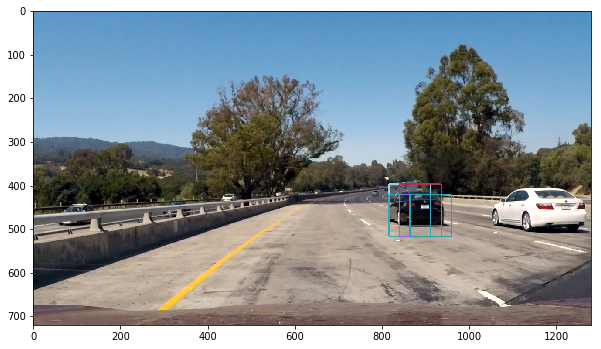

In [19]:
# for image in glob.glob('test_images/*.jpg'):
image='test_images/test1.jpg'
img=mpimg.imread(image)
rectangles=[]

ystart = 300
ystop = 600
scale = 1.5
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                             cell_per_block, spatial_size, hist_bins))

ystart = 350
ystop = 450
scale = 1.5
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
# print(len(rectangles))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                         cell_per_block, spatial_size, hist_bins))
print(len(rectangles))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
print(len(rectangles))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
print(len(rectangles))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
print(len(rectangles))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
print(len(rectangles))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
print(len(rectangles))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
print(len(rectangles))
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

/Users/shubhrc/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


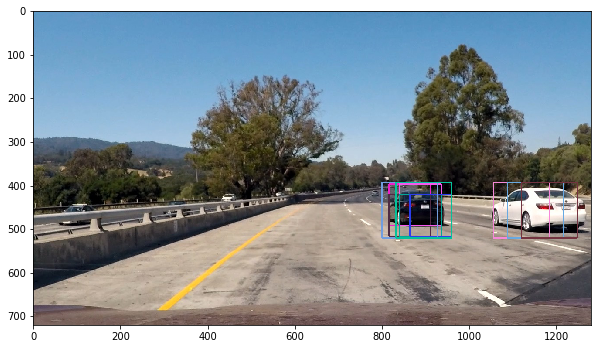

In [24]:
rectangles=[]
ystart = 300
ystop = 600
scale = 1.5
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
ystart=int(img.shape[0]*0.5)
ystop=int(img.shape[0]*0.95)
scale=2.0
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
# ystart=int(img.shape[0]*0.5)
# ystop=int(img.shape[0]*0.95)
# scale=1.0
# rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
#                             cell_per_block, spatial_size, hist_bins))
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

/Users/shubhrc/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


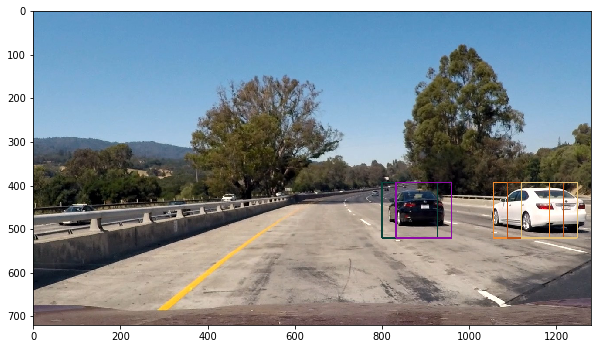

In [27]:
rectangles=[]
ystart = 300
ystop = 500
scale = 1.5
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
ystart=int(img.shape[0]*0.5)#400#
ystop=int(img.shape[0]*0.95)#550#
scale=2.0
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))

ystart=500#int(img.shape[0]*0.5)
ystop=700#int(img.shape[0]*0.95)
scale=2.5
rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins))
# ystart=int(img.shape[0]*0.5)
# ystop=int(img.shape[0]*0.95)
# scale=1.0
# rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
#                             cell_per_block, spatial_size, hist_bins))
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

/Users/shubhrc/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


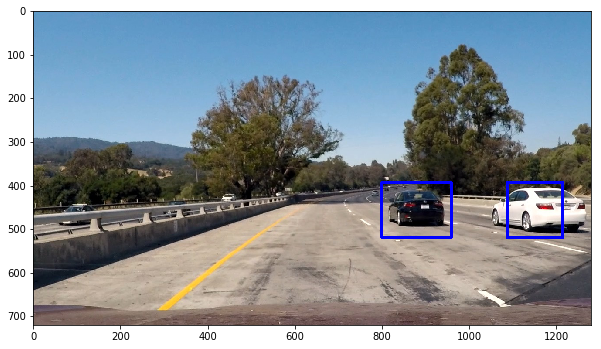

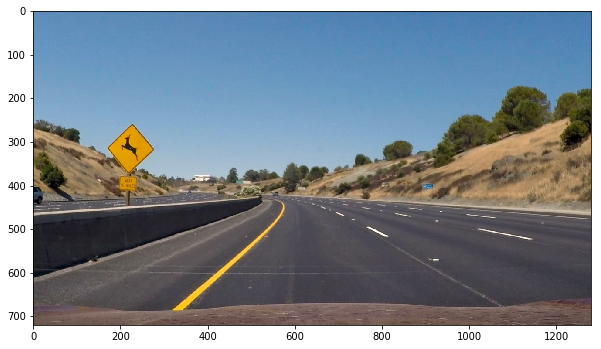

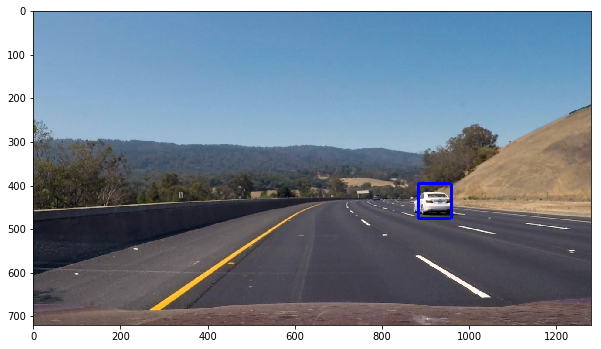

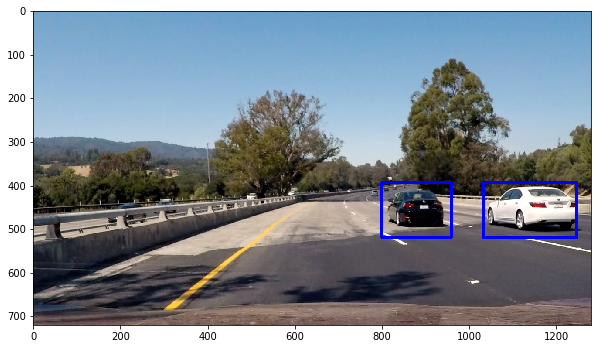

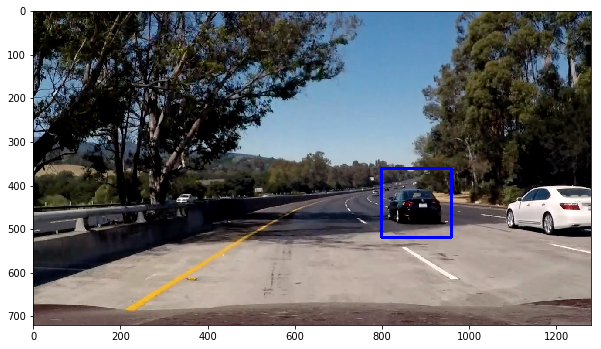

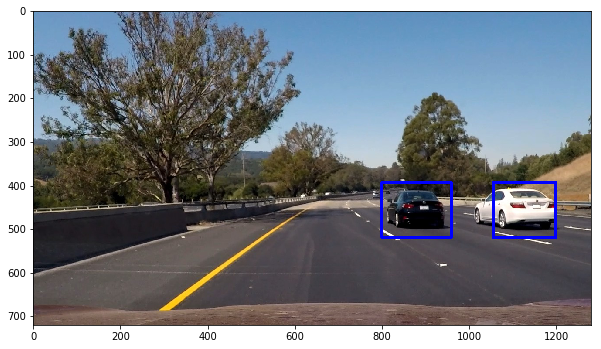

In [38]:
for image in glob.glob('test_images/*.jpg'):
    #image='test_images/test1.jpg'
    img=mpimg.imread(image)
    rectangles=[]
    ystart = 300
    ystop = 500
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))
    ystart = 300
    ystop = 500
    scale = 1.2
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))
    ystart = 300
    ystop = 600
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))
    ystart=int(img.shape[0]*0.5)#400#
    ystop=int(img.shape[0]*0.95)#550#
    scale=2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))

    ystart=400#int(img.shape[0]*0.5)
    ystop=700#int(img.shape[0]*0.95)
    scale=2.5
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))
    rectangles = [item for sublist in rectangles for item in sublist] 
    #test_img_rects = draw_boxes(img, rectangles, color='random', thick=2)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,rectangles)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    plt.figure(figsize=(10,10))
    plt.imshow(draw_img)
    plt.show()

In [72]:
img.shape[0]

720

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('...')

In [34]:
def add_heat(heatmap, bbox_list):
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [40]:
def process_img(img):

    rectangles=[]
    ystart = 300
    ystop = 500
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))
    ystart = 300
    ystop = 500
    scale = 1.2
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))
    ystart = 300
    ystop = 600
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))
    ystart=int(img.shape[0]*0.5)#400#
    ystop=int(img.shape[0]*0.95)#550#
    scale=2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))

    ystart=400#int(img.shape[0]*0.5)
    ystop=700#int(img.shape[0]*0.95)
    scale=2.5
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))
    rectangles = [item for sublist in rectangles for item in sublist] 
    #test_img_rects = draw_boxes(img, rectangles, color='random', thick=2)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,rectangles)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [42]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(28,33)

#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_img)

#NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 99%|█████████▉| 125/126 [1:15:18<00:36, 36.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 1h 13min 55s, sys: 17.6 s, total: 1h 14min 13s
Wall time: 1h 15min 20s


In [44]:

def process_img_1(img, list_params):

    rectangles=[]
    for l in list_params:
        ystart=l[0]
        ystop = l[1]
        scale = l[2]
        rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    #test_img_rects = draw_boxes(img, rectangles, color='random', thick=2)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,rectangles)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

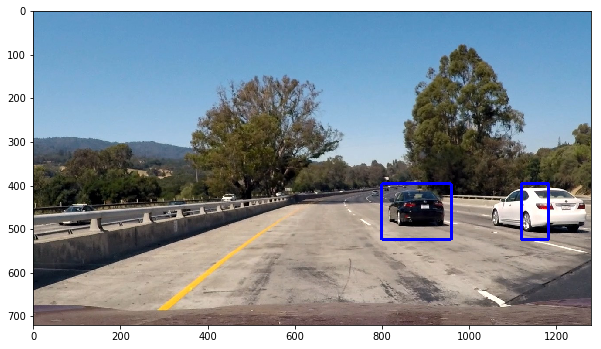

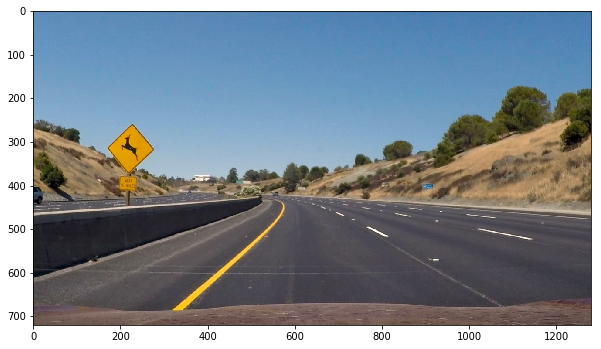

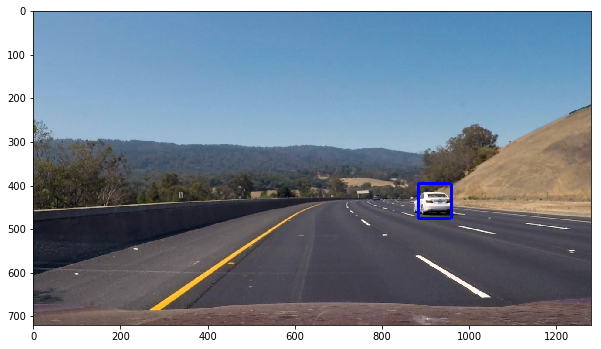

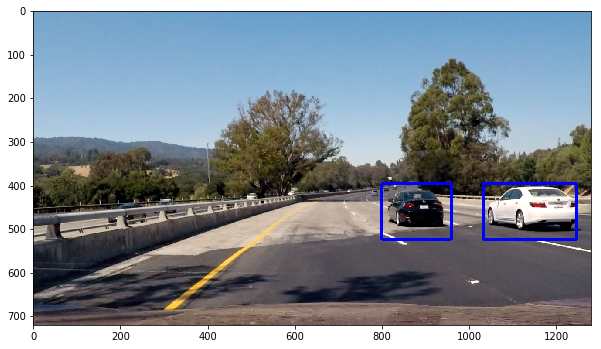

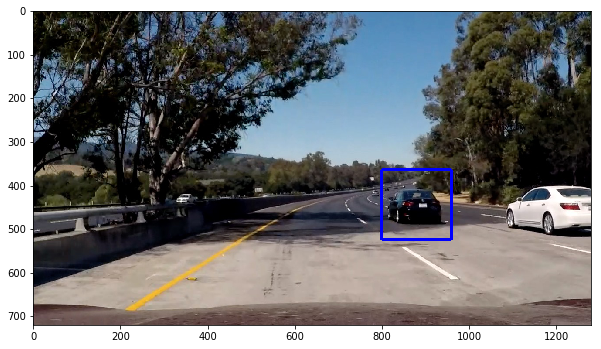

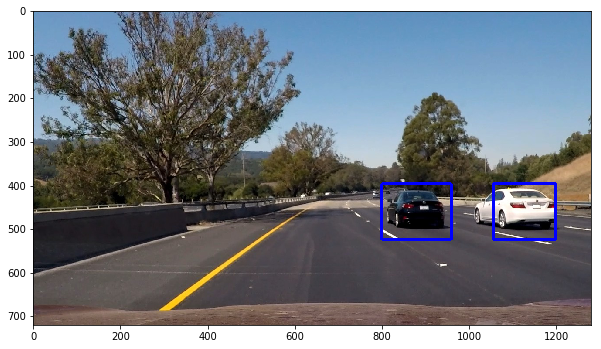

In [46]:
#rect_param_list =[(400,464,1.0),(416,480,1.0),(400,496,1.5),(432,528,1.5),(400,528,2.0),(432,560,2.0),(400,596,3.5),(464,660,3.5)]
rect_param_list=[(300,500,1.0),(300,500,1.2),(300,600,1.5),(300,600,2.0),(400,700,2.5)]
for image in glob.glob('test_images/*.jpg'):
    #image='test_images/test1.jpg'
    img=mpimg.imread(image)
    draw_img=process_img_1(img,rect_param_list)
    plt.figure(figsize=(10,10))
    plt.imshow(draw_img)
    plt.show()

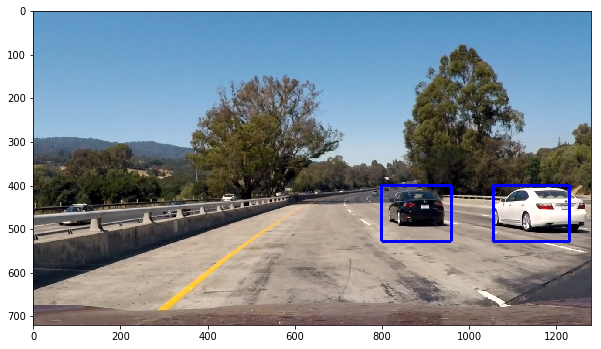

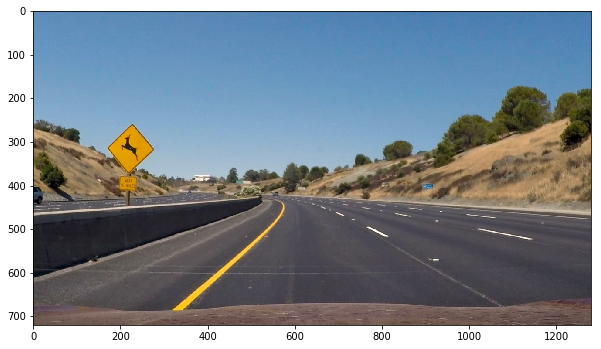

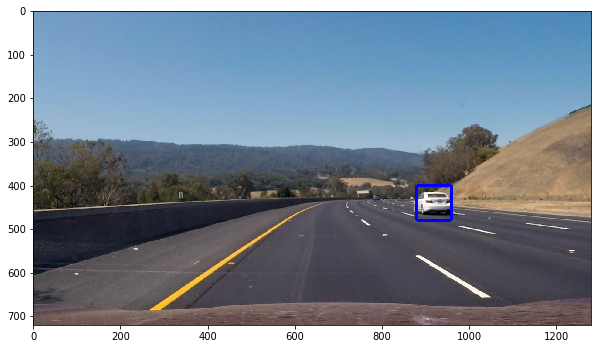

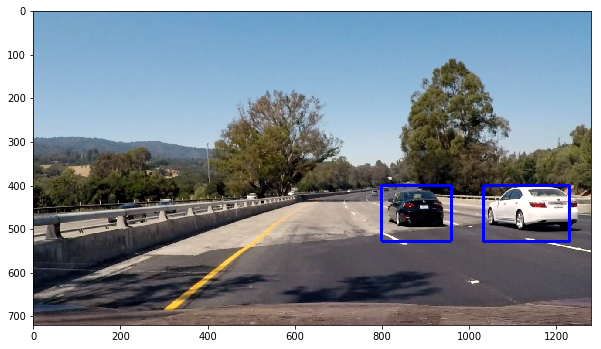

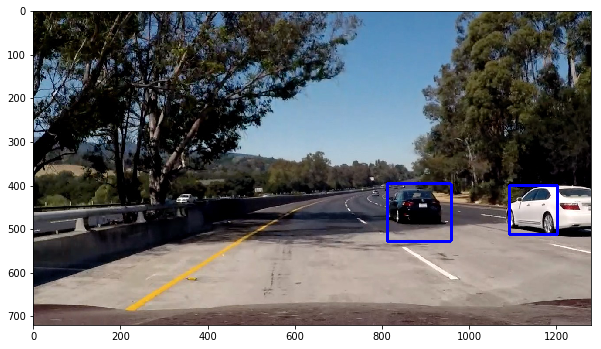

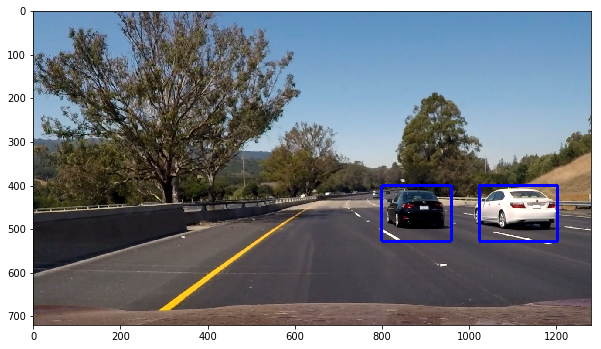

In [49]:
rect_param_list=[(300,500,1.0),(300,500,1.25),(400,600,1.5),(400,600,1.75),(400,600,2.0),(400,600,2.5),(500,700,3.0)]
for image in glob.glob('test_images/*.jpg'):
    #image='test_images/test1.jpg'
    img=mpimg.imread(image)
    draw_img=process_img_1(img,rect_param_list)
    plt.figure(figsize=(10,10))
    plt.imshow(draw_img)
    plt.show()

In [61]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

print('...')

def process_img_for_video(img):
    #rect_param_list=[(300,500,1.0),(300,500,1.25),(400,600,1.5),(400,600,1.75),(400,600,2.0),(400,600,2.5),(500,700,3.0)]
    rect_param_list=[(380,500,1.0),(380,500,1.25),(400,600,1.5),(400,600,1.75),(400,600,2.0),(400,600,2.5),(500,700,3.0)]

    rectangles=[]
    for l in rect_param_list:
        ystart=l[0]
        ystop = l[1]
        scale = l[2]
        rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    #test_img_rects = draw_boxes(img, rectangles, color='random', thick=2)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    for rect_set in det.prev_rects:
        heat = add_heat(heat, rect_set)
    heat = apply_threshold(heat, 1 + len(det.prev_rects)//2)    

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

...


In [63]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
det = Vehicle_Detect()
white_output = 'output_videos/project_video_stable_12_17.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(12,17)

#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_img_for_video)

#NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_stable_12_17.mp4
[MoviePy] Writing video output_videos/project_video_stable_12_17.mp4


 99%|█████████▉| 125/126 [35:13<00:17, 17.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_stable_12_17.mp4 

CPU times: user 34min 43s, sys: 13.5 s, total: 34min 56s
Wall time: 35min 14s


In [60]:
len(det.prev_rects)//2


7